In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from astropy.table import Table
import GCRCatalogs
from GCR import GCRQuery
import statistics
import os, sys
import healpy as hp
from tqdm.auto import tqdm, trange
import scipy.stats
import FoFCatalogMatching
import pandas as pd
from astropy.coordinates import SkyCoord
from scipy.stats import pearsonr
import warnings

In [2]:
warnings.filterwarnings('ignore')

## CosmoDC2, DC2 objects :

In [3]:
cosmodc2 = GCRCatalogs.load_catalog('cosmoDC2_v1.1.4_image') #truth catalog
dc2 = GCRCatalogs.load_catalog('dc2_object_run2.2i_dr6_with_addons') #object catalog

In [4]:
cosmodc2.list_all_native_quantities

<bound method BaseGenericCatalog.list_all_native_quantities of <GCRCatalogs.cosmodc2.CosmoDC2GalaxyCatalog object at 0x7f0168488160>>

#### Filters :

In [5]:
mag_cut = [(np.isfinite, 'mag_i_cModel'), (np.isfinite, 'mag_r_cModel')] #we remove the uncorrected measured magnitudes ('NaN' number)

#### Object data :

In [6]:
quantities_object= ['ra', 'dec', 'mag_i_cModel', 'photoz_mean']
object_data=(dc2.get_quantities(quantities_object,
                                filters=['extendedness>0', 'clean']+mag_cut,
                                native_filters=['tract==4026']))

#### Truth data :

In [7]:
eps = 10/3600 # 10 arcsec
max_ra = np.nanmax(object_data['ra']) + eps
min_ra = np.nanmin(object_data['ra']) - eps
max_dec = np.nanmax(object_data['dec']) + eps
min_dec = np.nanmin(object_data['dec']) - eps
pos_filters = [f'ra >= {min_ra}',f'ra <= {max_ra}', f'dec >= {min_dec}', f'dec <= {max_dec}']

vertices = hp.ang2vec(np.array([min_ra, max_ra, max_ra, min_ra]),
                      np.array([min_dec, min_dec, max_dec, max_dec]), lonlat=True)
ipix = hp.query_polygon(32, vertices, inclusive=True)
healpix_filter = GCRQuery((lambda h: np.isin(h, ipix, True), "healpix_pixel"))

In [8]:
quantities_truth=['galaxy_id', 'ra', 'dec', 'mag_i', 'redshift', 'halo_mass', 'is_central']
truth_data = cosmodc2.get_quantities(quantities_truth,
                                     filters=[(np.isfinite, 'mag_i'),(np.isfinite, 'mag_r')]+pos_filters, 
                                     native_filters=healpix_filter)

In [9]:
print("nbr of galaxies=", truth_data['ra'])
print("nbr of object=", object_data['ra'])

nbr of galaxies= [57.69217614 57.60349094 57.65726924 ... 58.0064114  57.58332201
 56.47602547]
nbr of object= [58.20039686 58.17906019 58.10063705 ... 56.62869145 56.62888171
 56.45513161]


### Magnitude pour objets et galaxies dans l'IR:

(array([1.000000e+00, 0.000000e+00, 0.000000e+00, 0.000000e+00,
       0.000000e+00, 4.000000e+00, 1.000000e+00, 2.000000e+00,
       3.000000e+00, 1.700000e+01, 3.400000e+01, 4.300000e+01,
       9.800000e+01, 1.560000e+02, 3.030000e+02, 5.310000e+02,
       8.260000e+02, 1.336000e+03, 2.098000e+03, 3.345000e+03,
       4.796000e+03, 7.143000e+03, 1.007000e+04, 1.418700e+04,
       1.899600e+04, 2.608200e+04, 3.858100e+04, 5.597100e+04,
       7.829200e+04, 1.097010e+05, 1.589040e+05, 2.283340e+05,
       3.286280e+05, 4.630210e+05, 6.074260e+05, 7.717470e+05,
       9.563050e+05, 1.076708e+06, 1.118668e+06, 1.057304e+06,
       9.625890e+05, 9.003640e+05, 8.072670e+05, 6.890960e+05,
       5.184270e+05, 2.374150e+05, 7.043900e+04, 2.670400e+04,
       8.710000e+02, 4.700000e+01]), array([11.48444462, 11.94335051, 12.4022564 , 12.86116229, 13.32006818,
       13.77897408, 14.23787997, 14.69678586, 15.15569175, 15.61459764,
       16.07350353, 16.53240942, 16.99131532, 17.45022121, 17.

(array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04, 1.e+05,
        1.e+06, 1.e+07, 1.e+08]),
 [Text(0, 0.01, '$\\mathdefault{10^{-2}}$'),
  Text(0, 0.1, '$\\mathdefault{10^{-1}}$'),
  Text(0, 1.0, '$\\mathdefault{10^{0}}$'),
  Text(0, 10.0, '$\\mathdefault{10^{1}}$'),
  Text(0, 100.0, '$\\mathdefault{10^{2}}$'),
  Text(0, 1000.0, '$\\mathdefault{10^{3}}$'),
  Text(0, 10000.0, '$\\mathdefault{10^{4}}$'),
  Text(0, 100000.0, '$\\mathdefault{10^{5}}$'),
  Text(0, 1000000.0, '$\\mathdefault{10^{6}}$'),
  Text(0, 10000000.0, '$\\mathdefault{10^{7}}$'),
  Text(0, 100000000.0, '$\\mathdefault{10^{8}}$')])

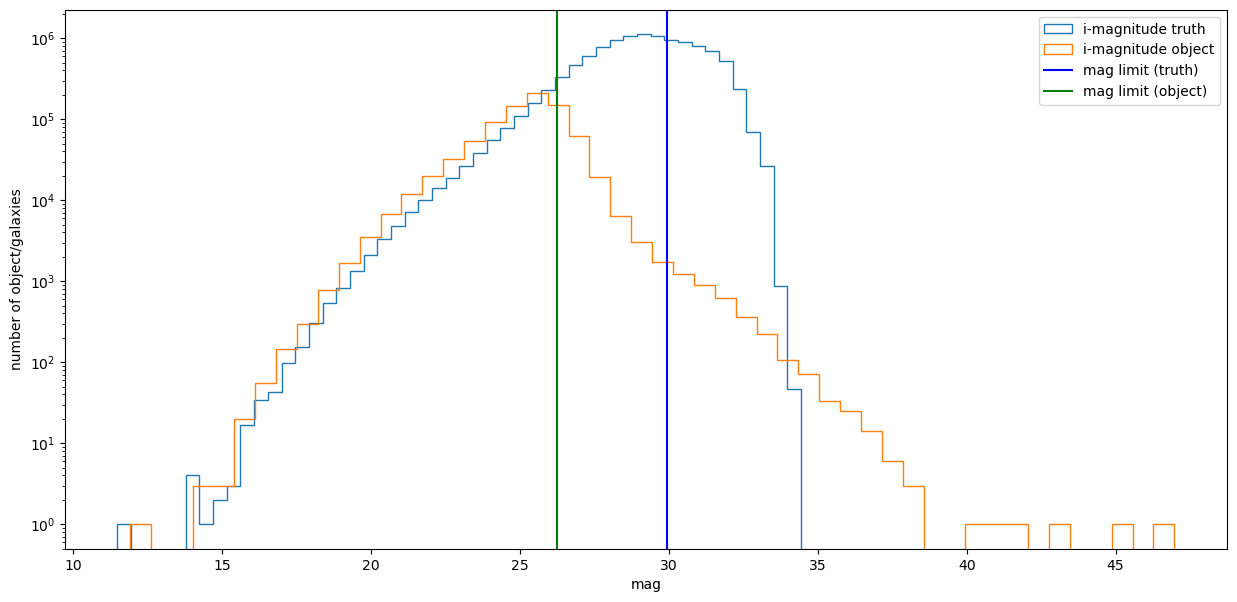

In [10]:
plt.figure(figsize=(15,7))
truth_hist=plt.hist(truth_data['mag_i'], bins=50, histtype='step', label='i-magnitude truth', log=True)
print(truth_hist)
object_hist=plt.hist(object_data['mag_i_cModel'], bins=50, histtype='step', label='i-magnitude object', log=True)
print(object_hist)
plt.axvline(x=29.922868494851375, label='mag limit (truth)', color='b')
plt.axvline(x=26.225850759523134, label='mag limit (object)', color='g')
plt.legend()
plt.xlabel('mag')
plt.ylabel('number of object/galaxies')
plt.xticks()
plt.yticks()

In [11]:
def mag_lim(data_hist):
    bins_max=np.argmax(data_hist[0])    #to find bins with the maximum object
    return data_hist[1][bins_max]     # give mag_max thus limit

print("mag limit for galaxies :", mag_lim(truth_hist))
print("mag limit for objects :", mag_lim(object_hist))

#mag limit before matching with FoF (+1 in mag)

mag limit for galaxies : 28.922868494851375
mag limit for objects : 25.225850759523134


### Z-cut :

In [12]:
z_truth=truth_data['redshift'][np.where(truth_data['redshift'] <=1.5)]
mag_truth=truth_data['mag_i'][np.where(truth_data['redshift'] <=1.5)]

In [13]:
z_object=object_data['photoz_mean'][np.where(object_data['photoz_mean'] <=1.5)]
mag_object=object_data['mag_i_cModel'][np.where(object_data['photoz_mean'] <=1.5)]

In [14]:
print(len(z_truth))
print(len(mag_truth))

3605521
3605521


Text(0, 0.5, 'magnitude')

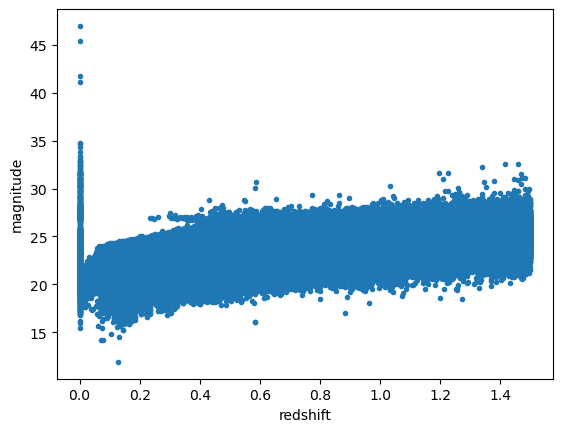

In [16]:
plt.figure()
'''plt.subplots_adjust(left=0.1, right=1, wspace=0.5)

plt1=plt.subplot(121)
plt.plot(z_truth, mag_truth)
plt.xlabel('redshift')
plt.ylabel('magnitude')

plt2=plt.subplot(122)'''
plt.plot(z_object, mag_object, '.')
plt.xlabel('redshift')
plt.ylabel('magnitude')